In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import numpy as np
from torchvision import transforms, models
import tqdm
import pickle

In [2]:
CLASSES = ['paper', 'rock', 'scissors', 'null']

In [6]:
class RPSMultiLabelDataset(Dataset):
    def __init__(self, images_dir, labels_dir, img_size, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.img_size = img_size
        self.transform = transform
        
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        # Multi-label: [rock_present, paper_present, scissors_present, null_present]
        self.classes = ['paper', 'rock', 'scissors', 'null']
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.resize(image, (self.img_size, self.img_size))
        
        labels = torch.zeros(4, dtype=torch.float32)
        
        # Load YOLO labels
        label_name = img_name.rsplit('.', 1)[0] + '.txt'
        label_path = os.path.join(self.labels_dir, label_name)
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                found_gesture = False
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        if class_id < 3:  # paper, rock, scissors
                            labels[class_id] = 1.0
                            found_gesture = True
                
                # If no gestures found, mark as null
                if not found_gesture:
                    labels[3] = 1.0  # null class
        else:
            # No label file means null image
            labels[3] = 1.0
        
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32) / 255.0
        
        return image, labels

In [7]:
class MultilabelCNN(nn.Module):

    def __init__(self, input_size=640, num_classes=4, dropout_rate=0.5):
        super(MultilabelCNN, self).__init__()
        
        self.input_size = input_size
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        # Pooling and dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
        
        self.feature_size = self._get_conv_out_size()
        self.fc1 = nn.Linear(self.feature_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)  # 4 classes for multi-label
        
    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        # Flatten
        x = x.view(-1, self.feature_size)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        # Output layer (logits)
        logits = self.fc3(x)
        
        # Apply sigmoid for multi-label (each class independent)
        probabilities = torch.sigmoid(logits)
        
        return logits, probabilities
    
    def _get_conv_out_size(self):
        dummy_input = torch.zeros(1, 3, self.input_size, self.input_size)
        x = self.pool(F.relu(self.conv1(dummy_input)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        return x.view(1, -1).size(1)

IMG_SIZE = 640
IMG_RESIZE = 320
BATCH_SIZE = 64

# Training function for CNN
def train_cnn_multilabel():

    train_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMG_RESIZE, IMG_RESIZE)), 
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Dataset and loader
    dataset_path = "../rock-paper-scissors-11"
    train_dataset = RPSMultiLabelDataset(
        images_dir=f'{dataset_path}/train/images',
        labels_dir=f'{dataset_path}/train/labels',
        img_size=640,
        transform=train_transforms
    )
    
    val_dataset = RPSMultiLabelDataset(
        images_dir=f'{dataset_path}/valid/images',
        labels_dir=f'{dataset_path}/valid/labels',
        img_size=640,
        transform=train_transforms
    )
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MultilabelCNN(input_size=IMG_RESIZE, num_classes=4).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")
    print(f"Training on {device}")
    
    # Training loop
    num_epochs = 15
    best_val_loss = float('inf')
    results_training = []
            
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_loop = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for batch_idx, (images, labels) in enumerate(train_loop):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            logits, probabilities = model(images)
            
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Calculate accuracy
            predictions = (probabilities > 0.5).float()
            train_correct += (predictions == labels).sum().item()
            train_total += labels.numel()
            
            train_loop.set_postfix(loss=loss.item())
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_loop = tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for images, labels in val_loop:
                images, labels = images.to(device), labels.to(device)
                
                logits, probabilities = model(images)
                loss = criterion(logits, labels)
                
                val_loss += loss.item()
                
                predictions = (probabilities > 0.5).float()
                val_correct += (predictions == labels).sum().item()
                val_total += labels.numel()
                
                val_loop.set_postfix(loss=loss.item())
        
        # Calculate epoch metrics
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.4f}')
        print('-' * 60)
        
        results_training.append({'epoch': epoch + 1, 'train_loss': train_loss_avg, 'val_loss': val_loss_avg, 'train_acc': train_acc, 'val_acc': val_acc})
        
        # Save best model
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            torch.save(model.state_dict(), 'best_cnn_multilabel_model.pth')
            print(f"New best model saved with validation loss: {val_loss_avg:.4f}")
        
        scheduler.step()
    
    return model, results_training

# Test the CNN model
def test_cnn_multilabel(model, dataset_path):
    model.eval()
    device = next(model.parameters()).device
    
    test_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMG_RESIZE, IMG_RESIZE)), 
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_dataset = RPSMultiLabelDataset(
        images_dir=f'{dataset_path}/test/images',
        labels_dir=f'{dataset_path}/test/labels',
        img_size=640,
        transform=test_transforms
    )
    
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for images, labels in tqdm.tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            
            logits, probabilities = model(images)
            predictions = (probabilities > 0.5).float()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels), np.array(all_probabilities)


In [4]:
# Train the CNN model
cnn_model, train_results = train_cnn_multilabel()

Model has 52883908 parameters
Training on cpu


Epoch 1/15 [Val]: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s, loss=0.547]


Epoch [1/15]
Train Loss: 0.5684, Train Acc: 0.7364
Val Loss: 0.5537, Val Acc: 0.7428
------------------------------------------------------------
New best model saved with validation loss: 0.5537


Epoch 2/15 [Val]: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s, loss=0.56]


Epoch [2/15]
Train Loss: 0.5515, Train Acc: 0.7487
Val Loss: 0.5528, Val Acc: 0.7440
------------------------------------------------------------
New best model saved with validation loss: 0.5528


Epoch 3/15 [Val]: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s, loss=0.516]


Epoch [3/15]
Train Loss: 0.5339, Train Acc: 0.7589
Val Loss: 0.5184, Val Acc: 0.7679
------------------------------------------------------------
New best model saved with validation loss: 0.5184


Epoch 4/15 [Val]: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s, loss=0.462]


Epoch [4/15]
Train Loss: 0.5162, Train Acc: 0.7671
Val Loss: 0.5036, Val Acc: 0.7687
------------------------------------------------------------
New best model saved with validation loss: 0.5036


Epoch 5/15 [Val]: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it, loss=0.464]


Epoch [5/15]
Train Loss: 0.5001, Train Acc: 0.7742
Val Loss: 0.4845, Val Acc: 0.7793
------------------------------------------------------------
New best model saved with validation loss: 0.4845


Epoch 6/15 [Val]: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s, loss=0.405]


Epoch [6/15]
Train Loss: 0.4883, Train Acc: 0.7785
Val Loss: 0.4492, Val Acc: 0.7959
------------------------------------------------------------
New best model saved with validation loss: 0.4492


Epoch 7/15 [Val]: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s, loss=0.346]


Epoch [7/15]
Train Loss: 0.4609, Train Acc: 0.7909
Val Loss: 0.4405, Val Acc: 0.7951
------------------------------------------------------------
New best model saved with validation loss: 0.4405


Epoch 8/15 [Val]: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s, loss=0.386]


Epoch [8/15]
Train Loss: 0.4275, Train Acc: 0.8060
Val Loss: 0.4057, Val Acc: 0.8176
------------------------------------------------------------
New best model saved with validation loss: 0.4057


Epoch 9/15 [Val]: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s, loss=0.371]


Epoch [9/15]
Train Loss: 0.3997, Train Acc: 0.8182
Val Loss: 0.3993, Val Acc: 0.8219
------------------------------------------------------------
New best model saved with validation loss: 0.3993


Epoch 10/15 [Val]: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s, loss=0.364]


Epoch [10/15]
Train Loss: 0.3660, Train Acc: 0.8359
Val Loss: 0.3861, Val Acc: 0.8316
------------------------------------------------------------
New best model saved with validation loss: 0.3861


Epoch 11/15 [Val]: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s, loss=0.278]


Epoch [11/15]
Train Loss: 0.3119, Train Acc: 0.8621
Val Loss: 0.3684, Val Acc: 0.8372
------------------------------------------------------------
New best model saved with validation loss: 0.3684


Epoch 12/15 [Val]: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s, loss=0.258]


Epoch [12/15]
Train Loss: 0.2888, Train Acc: 0.8724
Val Loss: 0.3682, Val Acc: 0.8401
------------------------------------------------------------
New best model saved with validation loss: 0.3682


Epoch 13/15 [Val]: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s, loss=0.283]


Epoch [13/15]
Train Loss: 0.2784, Train Acc: 0.8764
Val Loss: 0.3787, Val Acc: 0.8431
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s, loss=0.259]


Epoch [14/15]
Train Loss: 0.2656, Train Acc: 0.8831
Val Loss: 0.3830, Val Acc: 0.8372
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s, loss=0.307]

Epoch [15/15]
Train Loss: 0.2568, Train Acc: 0.8863
Val Loss: 0.3913, Val Acc: 0.8418
------------------------------------------------------------


In [ ]:
import pickle

# Save the trained model and training results
# torch.save(cnn_model.state_dict(), "cnn_multilabel_final.pth")
# 
# with open("cnn_multilabel_train_results.pkl", "wb") as f:
#     pickle.dump(train_results, f)

### Plots and stats

Load saved model

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

def load_model_and_results():

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MultilabelCNN(input_size=IMG_RESIZE, num_classes=4).to(device)

    try:
        model.load_state_dict(torch.load('cnn_multilabel_final.pth', map_location=device))
    except FileNotFoundError:
        print("Model file 'cnn_multilabel_final.pth' not found")
        return None, None

    try:
        with open("cnn_multilabel_train_results.pkl", "rb") as f:
            train_results = pickle.load(f)
    except FileNotFoundError:
        print("Training results file 'cnn_multilabel_train_results.pkl' not found")
        return model, None

    return model, train_results

# Plot training history
def plot_training_history(train_results):
    """Plot training and validation loss/accuracy over epochs"""
    
    if train_results is None:
        print("No training results to plot")
        return
    
    epochs = [r['epoch'] for r in train_results]
    train_losses = [r['train_loss'] for r in train_results]
    val_losses = [r['val_loss'] for r in train_results]
    train_accs = [r['train_acc'] for r in train_results]
    val_accs = [r['val_acc'] for r in train_results]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=18)
    ax1.set_ylabel('Loss', fontsize=18)
    ax1.set_title('Training and Validation Loss', fontsize=20)
    ax1.legend(fontsize=16)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='both', labelsize=16)
    
    # Accuracy plot
    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, val_accs, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=18)
    ax2.set_ylabel('Accuracy', fontsize=18)
    ax2.set_title('Training and Validation Accuracy', fontsize=20)
    ax2.legend(fontsize=16)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='both', labelsize=16)

    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"Final Training Accuracy: {train_accs[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accs[-1]:.4f}")

# Test the loaded model and create comprehensive plots
def evaluate_and_plot_model(model):
    """Test the model and create detailed performance plots"""
    
    if model is None:
        print("No model to evaluate")
        return

    print("Testing the loaded model...")
    test_predictions, test_labels, test_probabilities = test_cnn_multilabel(model, "../rock-paper-scissors-11")
    
    # Calculate metrics
    exact_match_accuracy = (test_predictions == test_labels).all(axis=1).mean()
    element_wise_accuracy = (test_predictions == test_labels).mean()
    
    print(f"\nTest Results:")
    print(f"Exact Match Accuracy: {exact_match_accuracy:.4f}")
    print(f"Element-wise Accuracy: {element_wise_accuracy:.4f}")
    
    # Create comprehensive plots
    plot_multilabel_performance(test_predictions, test_labels, test_probabilities)

def plot_multilabel_performance(predictions, labels, probabilities):
    """Create comprehensive performance plots for multi-label classification"""
    
    # classes = ['Rock', 'Paper', 'Scissors', 'Null']
    classes = CLASSES
    
    # 1. Per-class confusion matrices
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for i, class_name in enumerate(classes):
        cm = confusion_matrix(labels[:, i], predictions[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                   xticklabels=['Absent', 'Present'], 
                   yticklabels=['Absent', 'Present'], annot_kws={"size": 16})
        axes[i].set_title(f'{class_name} - Confusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Per-class performance metrics
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    metrics_data = []
    for i, class_name in enumerate(classes):
        precision = precision_score(labels[:, i], predictions[:, i], zero_division=0)
        recall = recall_score(labels[:, i], predictions[:, i], zero_division=0)
        f1 = f1_score(labels[:, i], predictions[:, i], zero_division=0)
        
        metrics_data.append({
            'Class': class_name,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })
    
    # Create metrics bar plot
    df_metrics = pd.DataFrame(metrics_data)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(classes))
    width = 0.25
    
    bars1 = ax.bar(x - width, df_metrics['Precision'], width, label='Precision', alpha=0.8)
    bars2 = ax.bar(x, df_metrics['Recall'], width, label='Recall', alpha=0.8)
    bars3 = ax.bar(x + width, df_metrics['F1-Score'], width, label='F1-Score', alpha=0.8)
    
    ax.set_xlabel('Classes')
    ax.set_ylabel('Score')
    ax.set_title('Per-Class Performance Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()
    ax.set_ylim(0, 1.1)
    
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=16)
    
    add_value_labels(bars1)
    add_value_labels(bars2)
    add_value_labels(bars3)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Probability distribution plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, class_name in enumerate(classes):
        # Positive and negative class probability distributions
        pos_probs = probabilities[labels[:, i] == 1, i]
        neg_probs = probabilities[labels[:, i] == 0, i]
        
        axes[i].hist(neg_probs, bins=30, alpha=0.7, label=f'{class_name} Absent', color='red', density=True)
        axes[i].hist(pos_probs, bins=30, alpha=0.7, label=f'{class_name} Present', color='blue', density=True)
        axes[i].axvline(x=0.5, color='black', linestyle='--', label='Threshold (0.5)')
        axes[i].set_xlabel('Predicted Probability')
        axes[i].set_ylabel('Density')
        axes[i].set_title(f'{class_name} - Probability Distribution')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


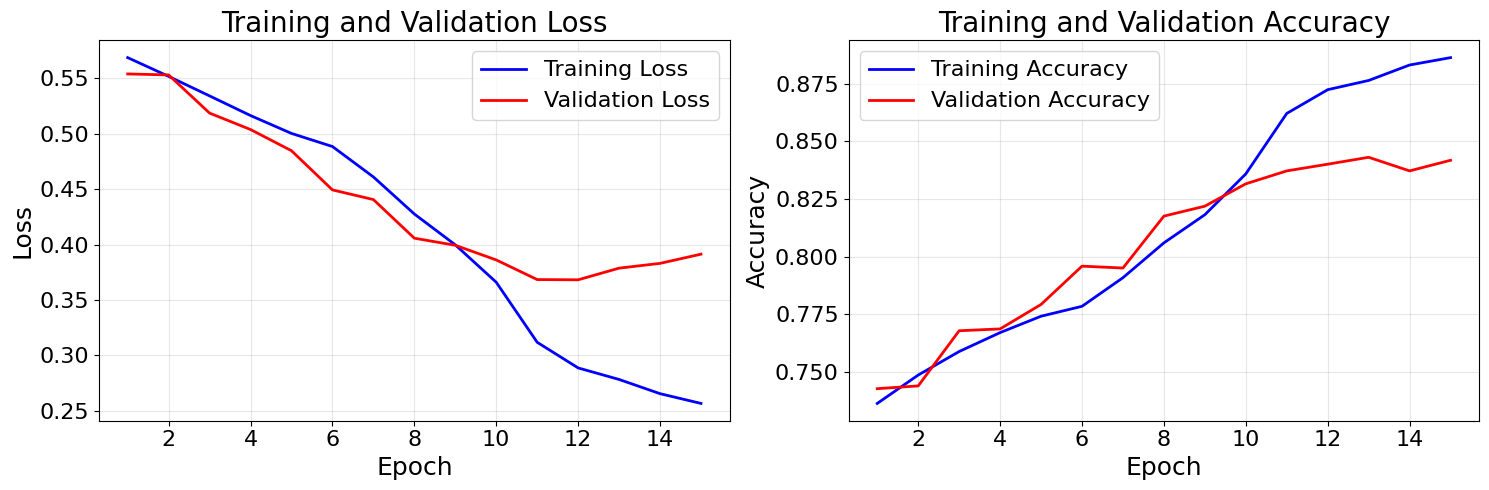

Final Training Loss: 0.2568
Final Validation Loss: 0.3913
Final Training Accuracy: 0.8863
Final Validation Accuracy: 0.8418
Testing the loaded model...


Testing: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]



Test Results:
Exact Match Accuracy: 0.6375
Element-wise Accuracy: 0.8711


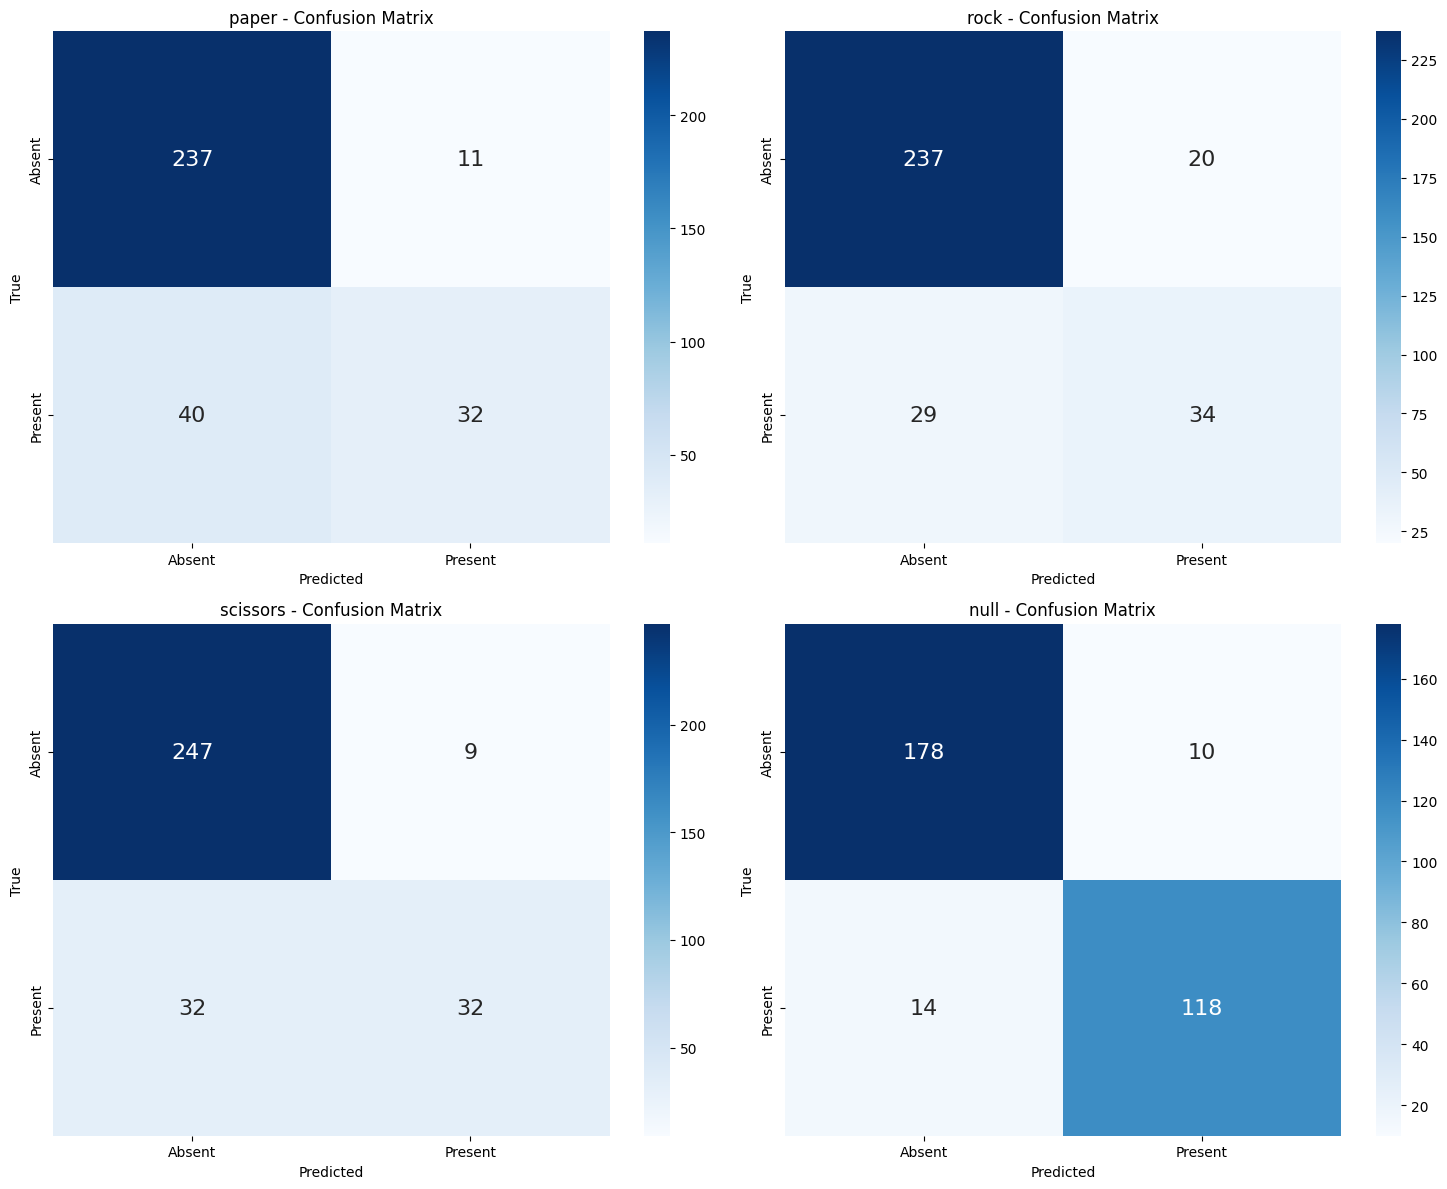

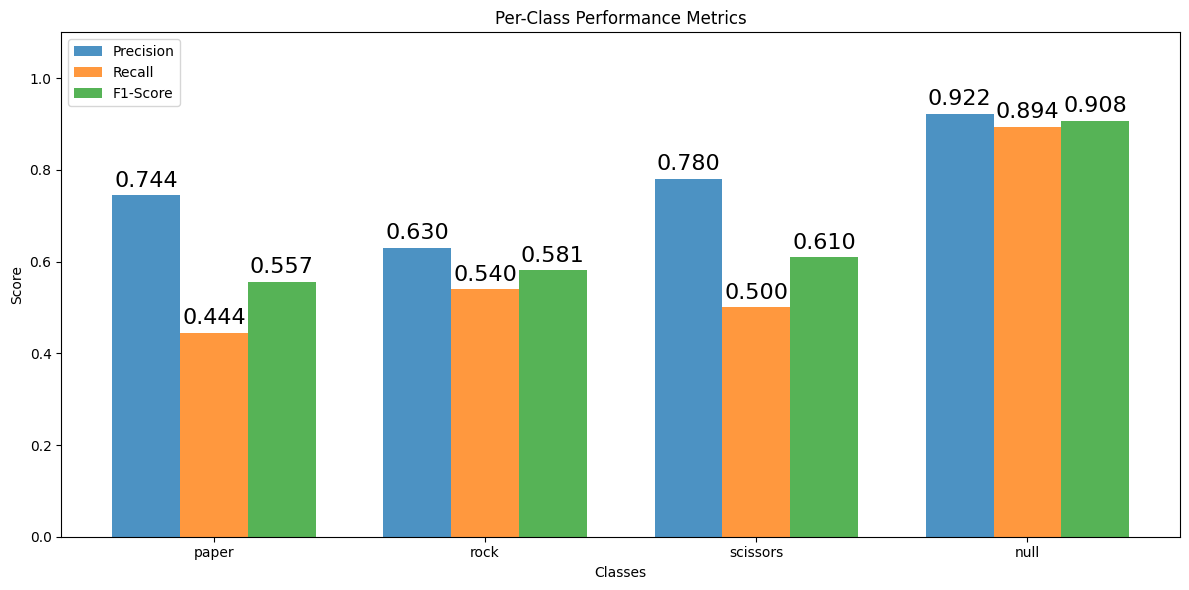

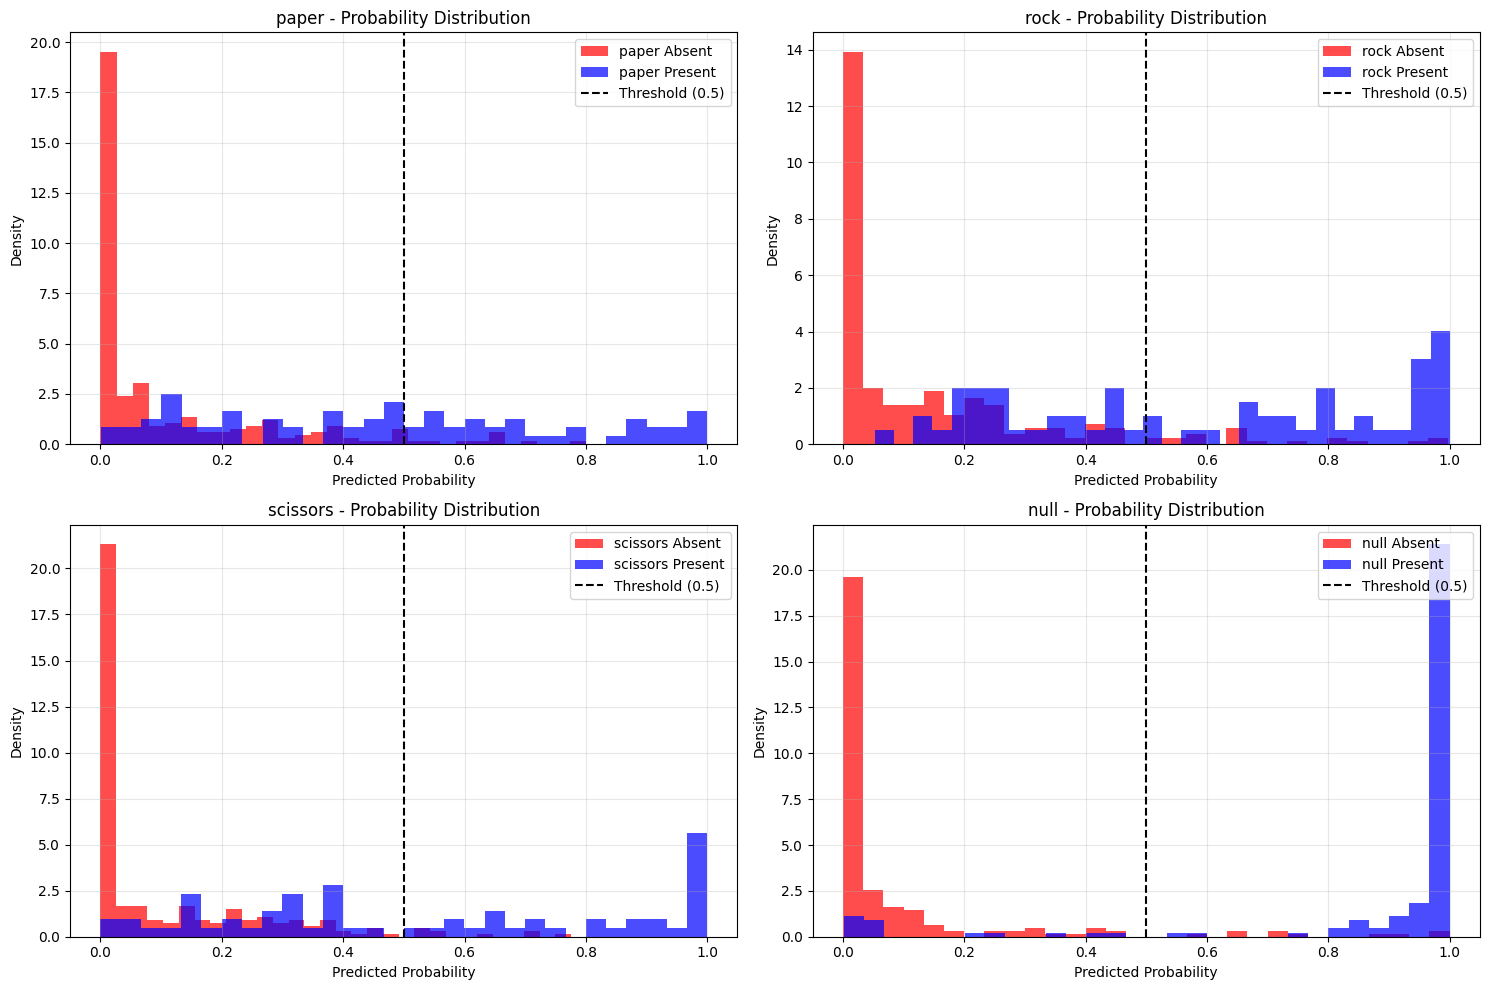

In [12]:
model, train_results = load_model_and_results()

if train_results is not None:
    plot_training_history(train_results)

if model is not None:
    evaluate_and_plot_model(model)